## *import libraries*

In [1]:
import functions as f

import os
import math
import pandas as pd
from tabulate import tabulate

import pm4py
from pm4py.algo.evaluation import algorithm
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from pm4py.objects.petri_net.importer.variants import pnml as pnml_importer
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments

import warnings
warnings.filterwarnings('ignore')

## *Config Settings*

In [2]:
params = {
    'session_duration': 0.6,  # any positive value
    'encoding': 'freq',   # freq, dur
    'clustering': 'DBSCAN',   # DBSCAN, KMEANS
    'eps': 0.01,    # any positive value, Recommended: 0-1
    'minSample': 196,   # any positive value
    'method': "sum",   # sum or mean
    'k': 2,  # any positive value
    'export_net': False,    # True, False
}

## *Read Event Log*

In [3]:
def UI_read_log(file_path):
    event_log = f.read_log(file_path)
    event_log['time:timestamp'] = pd.to_datetime(event_log['time:timestamp'], errors='coerce')
    event_log['time:timestamp'].ffill(inplace=True)
    event_log = event_log[['case:concept:name', 'time:timestamp', 'concept:name']]
    
    print("\n**  Total number of events: ", event_log.shape[0])
    print("**  Total number of columns: ", event_log.shape[1])
    print("**  Total number of Traces: ", len(event_log['case:concept:name'].unique()))
    print("**  Total number of unique activities: ", len(event_log['concept:name'].unique()))
    print("\n**  Unique Activites: ", event_log['concept:name'].unique())
    print("\n**  Columns: ", list(event_log.columns), "\n")
    return event_log

## *Clustering*

In [4]:
def UI_clustering(event_log):
    session_log, encoded_log, cluster_map = f.clustering(event_log, params)
    activity_log, _ = f.assign_clusters(session_log, encoded_log, cluster_map)
    
    print(f"\nActivity Log Columns: {activity_log.columns} \n")
    print(f"Total Routies: {len(activity_log['abstract_activity'].unique())} {list(activity_log['abstract_activity'].unique())}")
    return activity_log, cluster_map

## *Util Functions (Evaluation Scores)* 

In [5]:
# Extract transitions (activities) from both models to calculate Jaccard Coefficient
def extract_transitions(net):
    """ Extracts the transitions (activities) from the given Petri net model. """
    return {t.label for t in net.transitions if t.label is not None}


def get_fScore(fitness, precision):
    if fitness + precision == 0:
        return 0
    f_score = (2*fitness*precision)/(fitness+precision)
    return f_score


def get_JC(log, net, im, fm, routine_label):
    gt_routine_activities = extract_transitions(net)
    routine_activities = set(log['concept:name'])
    print(f"\nUnique Activities of {routine_label}:", routine_activities, "\n")
    print("Unique Activities of ground truth model:",gt_routine_activities, "\n")

    # Calculate the Jaccard Coefficient (Intersection over Union)
    intersection = routine_activities.intersection(gt_routine_activities)
    union = routine_activities.union(gt_routine_activities)
    jaccard_coefficient = len(intersection) / len(union)

    return jaccard_coefficient


def token_base_evaluation(log, net, im, fm):
    replayed_traces = token_replay.apply(log, net, im, fm)
    
    # Calculate Support (fraction of transitions supported by the log)
    activated_transitions = set()
    for trace in replayed_traces:
        for trans in trace['activated_transitions']:
            if trans is not None:  # Ensure the transition is valid
                activated_transitions.add(trans)
    total_transitions = len(net.transitions)
    support = len(activated_transitions) / total_transitions

    # Calculate Coverage
    covered_traces = sum([1 for trace in replayed_traces if trace['activated_transitions']])
    total_traces = len(log)
    coverage = covered_traces / total_traces

    return support, coverage
    

def alignment_base_evaluation(log, net, im, fm):
    # Apply alignment-based conformance checking
    aligned_traces = alignments.apply_log(log, net, im, fm)
    
    # Calculate Support (fraction of transitions supported by the log)
    activated_transitions = set()
    for trace in aligned_traces:
        for step in trace['alignment']:
            # Check if the step corresponds to a 'model move' (indicating a supported transition)
            if step[0] == step[1] and step[1] is not None:
                activated_transitions.add(step[1])
    total_transitions = len(net.transitions)
    support = len(activated_transitions) / total_transitions
    
    # Calculate Coverage (fraction of traces covered by at least one activated transition)
    covered_traces = sum(1 for trace in aligned_traces if any(step[0] == step[1] and step[1] is not None for step in trace['alignment']))
    total_traces = len(log)
    coverage = covered_traces / total_traces

    return support, coverage


def evaluate_routines(log, net, im, fm, token_base, routine_label):
    gt_routine_activities = extract_transitions(net)

    activity_counts = log['concept:name'].value_counts()
    noisy_threshold = math.ceil(len(log['case:concept:name'].unique()) * 0.05)
    noise_activities = activity_counts[activity_counts.values <= noisy_threshold].index.tolist()
    log_without_noise = log[~log['concept:name'].isin(noise_activities)]
    routine_activities = set(log_without_noise['concept:name'])

    # Calculate the Jaccard Coefficient (Intersection over Union)
    intersection = routine_activities.intersection(gt_routine_activities)
    union = routine_activities.union(gt_routine_activities)
    jaccard_coefficient = len(intersection) / len(union)

    log = pm4py.convert_to_event_log(log)
    support, coverage = token_base_evaluation(log, net, im, fm) if token_base else alignment_base_evaluation(log, net, im, fm)

    # Calculate fitness, precision, generalization, and F-score
    q_o = algorithm.apply(log, net, im, fm)
    fitness = round(q_o['fitness']['average_trace_fitness'],3)
    prec = round(q_o['precision'],3)
    gen = round(q_o['generalization'],3)
    simp = round(q_o['simplicity'],3)
    f_score = get_fScore(fitness, prec)

    # Print metrics
    print("\nEvaluation Scores:")
    print("=====================")
    print("Fitness: ", fitness)
    print("Precision: ", prec)
    print("Generalization: ", gen)
    print("Simplicity: ", simp)
    
    print(f"\nCoverage: {coverage:.2f}")
    print(f"Support: {support:.2f}")
    print(f"Jaccard Coefficient: {jaccard_coefficient:.2f}")

    return [routine_label, len(log), len(routine_activities), fitness, prec, gen, simp, f_score, coverage, support, jaccard_coefficient]

## *Evaluate UI Logs*

In [6]:
def UI_logs_evaluate(activity_log, cluster_map):
    key_value = 1
    for key, routine_label in cluster_map.items():
        print(f"Start Evaluating the {routine_label}:")
        routine_log = activity_log[activity_log['abstract_activity'] == routine_label]
        print(f"Total Traces: {len(routine_log['case:concept:name'].unique())}")
    
        # remove noisy activities
        activity_counts = routine_log['concept:name'].value_counts()
        noisy_threshold = math.ceil(len(routine_log['case:concept:name'].unique()) * 0.05)
        noise_activities = activity_counts[activity_counts.values <= noisy_threshold].index.tolist()
        routine_log_without_noise = routine_log[~routine_log['concept:name'].isin(noise_activities)]
        
        if len(noise_activities) > 0:
            print(f"{len(noise_activities)} noisy activities were found in {routine_label} and removed.")
            print(f"Now Unique activites in {routine_label} are {len(routine_log_without_noise['concept:name'].unique())}")
        
        JC_scores = {}
        for file_name in os.listdir(cpn_ground_truth_dir):
            model_name = file_name.split('.')[0]
            cpn_ground_truth_path = os.path.join(cpn_ground_truth_dir, file_name)
            gt_net, gt_im, gt_fm = pnml_importer.import_net(cpn_ground_truth_path)
            JC = get_JC(routine_log_without_noise, gt_net, gt_im, gt_fm, routine_label=routine_label)
            JC_scores[file_name] = JC
            print(f"JC Score of {routine_label} is {JC} with {model_name}")
            print("="*50)
            
        # Find the key with the maximum value
        max_key = max(JC_scores, key=JC_scores.get)
        max_value = JC_scores[max_key]
    
        # Output the result
        print(f"\nMaximum JC Score of {routine_label} is {max_value}")
    
        cpn_ground_truth_path = os.path.join(cpn_ground_truth_dir, max_key)
        gt_net, gt_im, gt_fm = pnml_importer.import_net(cpn_ground_truth_path)
        scores = evaluate_routines(routine_log, gt_net, gt_im, gt_fm, token_base=False, routine_label=routine_label)
        result_dic[key_value] = scores
        key_value += 1
        print("\n\n\n")
    return result_dic

## *Results Summary*

In [7]:
# # Function to calculate F-score given fitness and precision
# def calculate_f_score(fitness, precision):
#     if fitness + precision == 0:
#         return 0
#     return 2 * (fitness * precision) / (fitness + precision)

# # Function to calculate simple and weighted averages for a single result dictionary
# def UI_logs_summary(result_dic):
#     simple_average_values = ["Simple Average"]
#     weighted_average_values = ["Weighted Average"]

#     total_traces = sum(result_dic[key][1] for key in result_dic if isinstance(key, int))
#     simple_average_values.append(total_traces)
#     weighted_average_values.append(total_traces)

#     mean_fitness = mean_precision = weighted_fitness = weighted_precision = 0

#     for i in range(2, len(result_dic[1])):  
#         values = [result_dic[key][i] for key in result_dic if isinstance(key, int)]

#         simple_avg = sum(values) / len(values)
#         weighted_avg = sum(result_dic[key][i] * result_dic[key][1] for key in result_dic if isinstance(key, int)) / total_traces

#         if i == 3:  
#             mean_fitness = simple_avg
#             weighted_fitness = weighted_avg
#         elif i == 4:  
#             mean_precision = simple_avg
#             weighted_precision = weighted_avg

#         simple_average_values.append(simple_avg)
#         weighted_average_values.append(weighted_avg)

#     f_score_simple_avg = calculate_f_score(mean_fitness, mean_precision)
#     f_score_weighted_avg = calculate_f_score(weighted_fitness, weighted_precision)

#     simple_average_values[7] = f_score_simple_avg  
#     weighted_average_values[7] = f_score_weighted_avg

#     next_key_simple = max([key for key in result_dic if isinstance(key, int)], default=0) + 1
#     next_key_weighted = next_key_simple + 1

#     result_dic[next_key_simple] = simple_average_values
#     result_dic[next_key_weighted] = weighted_average_values

#     result_df = pd.DataFrame.from_dict(result_dic, orient='index', columns=["Metrics", "Traces", "Trace Length", "Fitness", "Precision", "Generalization", "Simplicity", "F-Score"])
#     result_df = result_df.set_index('Metrics')
#     print(tabulate(result_df, headers='keys', tablefmt='psql'))

#     return result_dic, simple_average_values  # Return the simple average row for aggregation

# # 🚀 New function to handle cross-validation and final aggregation
# def cross_validation_summary(cross_val_results):
#     """Performs cross-validation over multiple iterations, collects simple averages, and calculates final averages."""
#     iter_results = {}
#     simple_averages_list = []

#     for i, result_dic in enumerate(cross_val_results, start=1):
#         _, simple_avg_row = UI_logs_summary(result_dic)
#         iter_results[f"iter {i}"] = simple_avg_row[1:]  # Exclude the 'Simple Average' label
#         simple_averages_list.append(simple_avg_row[1:])

#     # Convert collected simple averages into a DataFrame
#     iter_df = pd.DataFrame(iter_results, index=["Traces", "Trace Length", "Fitness", "Precision", "Generalization", "Simplicity", "F-Score"])
#     iter_df = iter_df.T  # Iterations as rows
#     print("\n✅ Cross-Validation Iteration Results:")
#     print(tabulate(iter_df, headers='keys', tablefmt='psql'))

#     # 🧮 Final Simple and Weighted Averages
#     final_simple_avg = iter_df.mean().tolist()
#     total_traces = iter_df["Traces"].sum()
#     weighted_avg = [(iter_df[col] * iter_df["Traces"]).sum() / total_traces for col in iter_df.columns]

#     # 📢 Final Results Display
#     final_df = pd.DataFrame(
#         [final_simple_avg, weighted_avg],
#         index=["Final Simple Average", "Final Weighted Average"],
#         columns=["Traces", "Trace Length", "Fitness", "Precision", "Generalization", "Simplicity", "F-Score"]
#     )
#     print("\n🚀 Final Aggregated Results:")
#     print(tabulate(final_df, headers='keys', tablefmt='psql'))

#     return iter_df, final_df

In [8]:
#  Function to calculate F-score given fitness and precision
def calculate_f_score(fitness, precision):
    if fitness + precision == 0:
        return 0
    return 2 * (fitness * precision) / (fitness + precision)

#  Function to calculate simple and weighted averages for a single result dictionary
def UI_logs_summary(result_dic):
    # Column names including Coverage, Support, and JC
    columns = ["Metrics", "Traces", "Trace Length", "Fitness", "Precision", 
               "Generalization", "Simplicity", "F-Score", "Coverage", "Support", "JC"]

    # Initialize lists for averages
    simple_average_values = ["Simple Average"]
    weighted_average_values = ["Weighted Average"]

    total_traces = sum(result_dic[key][1] for key in result_dic if isinstance(key, int))
    simple_average_values.append(total_traces)
    weighted_average_values.append(total_traces)

    mean_fitness = mean_precision = weighted_fitness = weighted_precision = 0

    # Iterate through metrics starting from index 2 ("Trace Length")
    for i in range(2, len(result_dic[1])):  
        values = [result_dic[key][i] for key in result_dic if isinstance(key, int)]

        simple_avg = sum(values) / len(values)
        weighted_avg = sum(result_dic[key][i] * result_dic[key][1] for key in result_dic if isinstance(key, int)) / total_traces

        simple_avg = round(simple_avg, 3)
        weighted_avg = round(weighted_avg, 3)
        
        if i == 3:  # Fitness column
            mean_fitness = simple_avg
            weighted_fitness = weighted_avg
        elif i == 4:  # Precision column
            mean_precision = simple_avg
            weighted_precision = weighted_avg

        simple_average_values.append(simple_avg)
        weighted_average_values.append(weighted_avg)

    #  Calculate and update the F-Score
    f_score_simple_avg = calculate_f_score(mean_fitness, mean_precision)
    f_score_weighted_avg = calculate_f_score(weighted_fitness, weighted_precision)

    # Update F-Score at the correct index (7th metric after 'Metrics' & 'Traces')
    simple_average_values[7] = round(f_score_simple_avg, 3)
    weighted_average_values[7] = round(f_score_weighted_avg, 3)

    #  Insert average rows into result_dic
    next_key_simple = max([key for key in result_dic if isinstance(key, int)], default=0) + 1
    next_key_weighted = next_key_simple + 1

    result_dic[next_key_simple] = simple_average_values
    result_dic[next_key_weighted] = weighted_average_values

    #  Convert to DataFrame and print
    result_df = pd.DataFrame.from_dict(result_dic, orient='index', columns=columns)
    result_df = result_df.set_index('Metrics')

    # print("\n Per-Log Summary:")
    # print(tabulate(result_df, headers='keys', tablefmt='psql'))

    return result_dic, simple_average_values  # Return simple average row for aggregation

#  Function to handle cross-validation and final aggregation
def cross_validation_summary(cross_val_results):
    """Performs cross-validation, collects simple averages, and calculates final averages."""
    iter_results = {}
    simple_averages_list = []

    #  Collect simple averages from each iteration
    for i, result_dic in enumerate(cross_val_results, start=1):
        _, simple_avg_row = UI_logs_summary(result_dic)
        iter_results[f"CV {i}"] = simple_avg_row[1:]  # Exclude 'Simple Average' label
        simple_averages_list.append(simple_avg_row[1:])

    #  Convert iteration results into DataFrame
    iter_columns = ["Traces", "Trace Length", "Fitness", "Precision", "Gen", 
                    "Simp", "F-Score", "Coverage", "Support", "JC"]
    iter_df = pd.DataFrame(iter_results, index=iter_columns).T

    print("\n Cross-Validation Iteration Results:")
    print(tabulate(iter_df, headers='keys', tablefmt='psql'))

    #  Final Simple and Weighted Averages
    final_simple_avg = iter_df.mean().tolist()
    total_traces = iter_df["Traces"].sum()
    weighted_avg = [(iter_df[col] * iter_df["Traces"]).sum() / total_traces for col in iter_df.columns]

    #  Final Aggregated Results
    final_df = pd.DataFrame(
        [final_simple_avg, weighted_avg],
        index=["Simple Average", "Weighted Average"],
        columns=iter_columns
    )

    print("\n Final Aggregated Results:")
    print(tabulate(final_df, headers='keys', tablefmt='outline'))

    return iter_df, final_df


## *main*

parsing log, completed traces :: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 305.00it/s]



**  Total number of events:  1396
**  Total number of columns:  3
**  Total number of Traces:  100
**  Total number of unique activities:  13

**  Unique Activites:  ['openFile_Excel_Sheet1_data_xls' 'goToUrl_www_webpage_com_Web'
 'insertValue_password_Web' 'clickButton_confirm_Web'
 'waitResponse_www_webpage_com_ok_Web' 'clickButton_Button1_Web'
 'clickButton_B2_Web' 'copy_B_Excel' 'insertValue_ID_Web' 'paste_Area_Web'
 'paste_Special_code_Web' 'clickButton_OK_Web' 'insertValue_username_Web']

**  Columns:  ['case:concept:name', 'time:timestamp', 'concept:name'] 

DBSCAN
freq




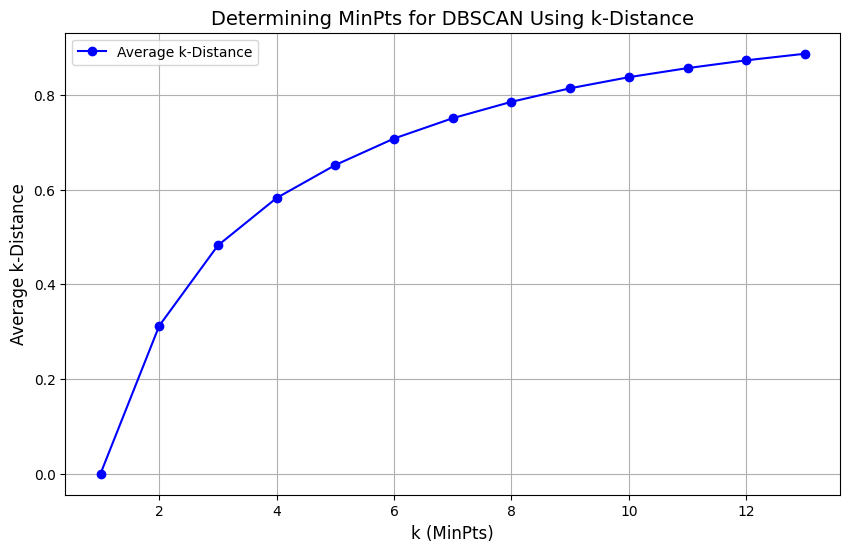

Optimal MinPts (k) identified: 13
sum
[0.         1.41421356 1.73205081 1.73205081 1.73205081 1.73205081
 2.         2.         2.         2.         2.         2.
 2.        ]
k-Distances Shape (100,)
k-Distances: [22.34241679 16.14213562  0.         14.07106781 11.         18.97469149
  0.         16.55634919 12.         12.         17.82769817  0.
 16.14213562  0.         15.72792206 11.         11.         11.
 16.14213562 15.72792206 16.14213562 15.72792206 14.48528137 19.09904715
  8.         16.14213562 12.         11.         15.72792206 11.
  0.         15.72792206 16.14213562 12.          0.         14.72792206
 16.14213562 12.         12.          0.          0.         18.87758622
  0.         11.         12.         11.         12.         21.00267083
 14.48528137 11.          0.         12.         16.14213562 11.
  0.         12.         17.19202368  8.          0.         16.55634919
 16.14213562  0.         16.14213562 16.14213562  0.         14.72792206
 19.19542346 1

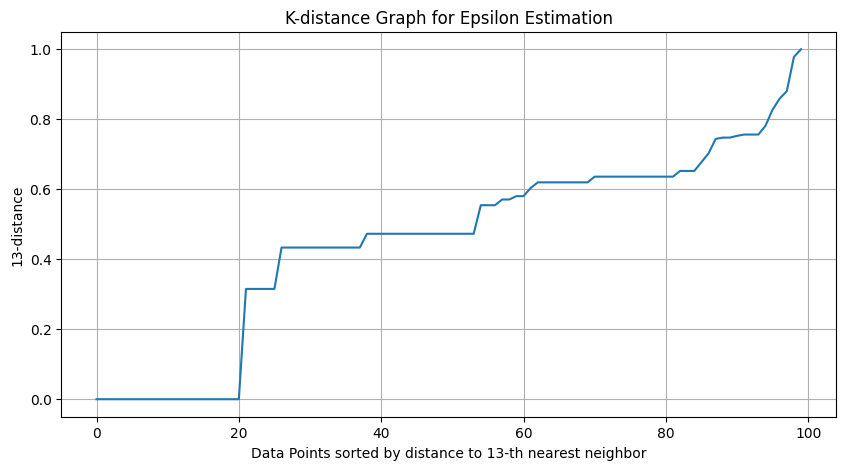

Optimal epsilon (eps) detected at index 93 with value: 0.7561859919415376
Epsilon value: 0.7561859919415376 and Minimum Points are: 13
 1    47
-1    45
 0     8
Name: DBSCAN_Cluster, dtype: int64

All noise points have been assigned to the nearest cluster.


 1    89
0    11
Name: DBSCAN_Cluster, dtype: int64 


Activity Log Columns: Index(['case:concept:name', 'time:timestamp', 'concept:name',
       'abstract_activity'],
      dtype='object') 

Total Routies: 2 ['routine_2', 'routine_1']
Start Evaluating the routine_2:
Total Traces: 89

Unique Activities of routine_2: {'insertValue_password_Web', 'paste_Area_Web', 'goToUrl_www_webpage_com_Web', 'insertValue_ID_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButton_Button1_Web', 'clickButton_B2_Web', 'paste_Special_code_Web', 'clickButton_confirm_Web', 'clickButton_OK_Web', 'copy_B_Excel', 'waitResponse_www_webpage_com_ok_Web', 'insertValue_username_Web'} 

Unique Activities of ground truth model: {'insertValue_password_Web', 'paste_Ar

replaying log with TBR, completed variants :: 100%|████████████████████████████████| 466/466 [00:00<00:00, 2110.84it/s]



Evaluation Scores:
Fitness:  0.906
Precision:  1.0
Generalization:  0.894
Simplicity:  1.0

Coverage: 1.00
Support: 0.93
Jaccard Coefficient: 1.00




Start Evaluating the routine_1:
Total Traces: 11

Unique Activities of routine_1: {'insertValue_password_Web', 'paste_Area_Web', 'goToUrl_www_webpage_com_Web', 'insertValue_ID_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButton_Button1_Web', 'clickButton_B2_Web', 'paste_Special_code_Web', 'clickButton_confirm_Web', 'clickButton_OK_Web', 'copy_B_Excel', 'waitResponse_www_webpage_com_ok_Web', 'insertValue_username_Web'} 

Unique Activities of ground truth model: {'insertValue_password_Web', 'paste_Area_Web', 'goToUrl_www_webpage_com_Web', 'insertValue_ID_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButton_B2_Web', 'clickButton_OK_Web', 'paste_Special_code_Web', 'clickButton_confirm_Web', 'clickButton_Button1_Web', 'copy_B_Excel', 'waitResponse_www_webpage_com_ok_Web', 'insertValue_username_Web'} 

JC Score of routine_1 is 1.0 with r1log

replaying log with TBR, completed variants :: 100%|██████████████████████████████████| 64/64 [00:00<00:00, 2376.69it/s]



Evaluation Scores:
Fitness:  0.864
Precision:  0.988
Generalization:  0.683
Simplicity:  1.0

Coverage: 1.00
Support: 0.93
Jaccard Coefficient: 1.00






parsing log, completed traces :: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 628.97it/s]



**  Total number of events:  1417
**  Total number of columns:  3
**  Total number of Traces:  100
**  Total number of unique activities:  13

**  Unique Activites:  ['copy_B_Excel' 'openFile_Excel_Sheet1_data_xls'
 'goToUrl_www_webpage_com_Web' 'insertValue_username_Web'
 'insertValue_password_Web' 'clickButton_confirm_Web'
 'waitResponse_www_webpage_com_ok_Web' 'clickButton_Button1_Web'
 'clickButton_B2_Web' 'insertValue_ID_Web' 'paste_Special_code_Web'
 'clickButton_OK_Web' 'paste_Area_Web']

**  Columns:  ['case:concept:name', 'time:timestamp', 'concept:name'] 

DBSCAN
freq




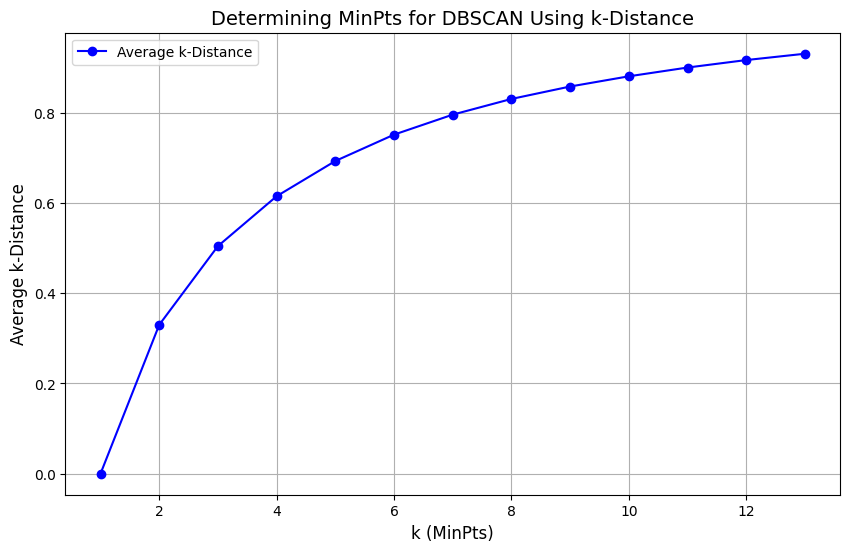

Optimal MinPts (k) identified: 13
sum
[0.         1.41421356 1.41421356 1.41421356 1.41421356 1.41421356
 1.41421356 1.41421356 1.41421356 1.41421356 1.41421356 1.41421356
 1.41421356]
k-Distances Shape (100,)
k-Distances: [16.97056275 16.55634919 12.          9.         15.72792206 16.55634919
  9.         26.1246118  19.51326071  0.         16.14213562 11.
 16.97056275  0.         21.58845727 16.14213562 11.          0.
 16.14213562  9.         10.          0.         11.         16.55634919
 12.         10.          9.          0.          0.         22.34241679
  0.         10.         11.         12.         12.          0.
 11.         16.14213562 11.         14.89949494 18.7812099  16.55634919
 15.3137085  19.19542346 12.         17.92407448  0.         26.36986621
 16.55634919 19.51326071 18.87758622  0.         20.1489352  11.
 14.3137085   0.          0.         24.16302198 20.1489352  12.
 19.73472164 16.14213562  0.          0.         14.3137085  12.
  0.         25.992910

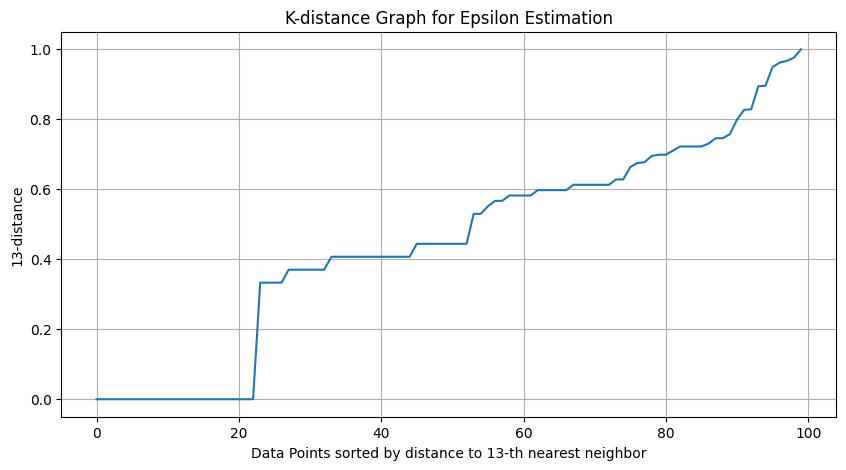

Optimal epsilon (eps) detected at index 86 with value: 0.7302775353337109
Epsilon value: 0.7302775353337109 and Minimum Points are: 13

No Cluster found, all points were noisy
0    100
Name: DBSCAN_Cluster, dtype: int64

Activity Log Columns: Index(['case:concept:name', 'time:timestamp', 'concept:name',
       'abstract_activity'],
      dtype='object') 

Total Routies: 1 ['routine_1']
Start Evaluating the routine_1:
Total Traces: 100

Unique Activities of routine_1: {'insertValue_password_Web', 'paste_Area_Web', 'goToUrl_www_webpage_com_Web', 'insertValue_ID_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButton_Button1_Web', 'clickButton_B2_Web', 'paste_Special_code_Web', 'clickButton_confirm_Web', 'clickButton_OK_Web', 'copy_B_Excel', 'waitResponse_www_webpage_com_ok_Web', 'insertValue_username_Web'} 

Unique Activities of ground truth model: {'insertValue_password_Web', 'paste_Area_Web', 'goToUrl_www_webpage_com_Web', 'insertValue_ID_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButt

replaying log with TBR, completed variants :: 100%|████████████████████████████████| 515/515 [00:00<00:00, 2623.32it/s]



Evaluation Scores:
Fitness:  0.89
Precision:  1.0
Generalization:  0.901
Simplicity:  1.0

Coverage: 1.00
Support: 0.93
Jaccard Coefficient: 1.00






parsing log, completed traces :: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 593.37it/s]



**  Total number of events:  1392
**  Total number of columns:  3
**  Total number of Traces:  100
**  Total number of unique activities:  13

**  Unique Activites:  ['openFile_Excel_Sheet1_data_xls' 'goToUrl_www_webpage_com_Web'
 'insertValue_username_Web' 'clickButton_Button1_Web'
 'insertValue_password_Web' 'clickButton_confirm_Web'
 'waitResponse_www_webpage_com_ok_Web' 'clickButton_B2_Web' 'copy_B_Excel'
 'paste_Special_code_Web' 'paste_Area_Web' 'clickButton_OK_Web'
 'insertValue_ID_Web']

**  Columns:  ['case:concept:name', 'time:timestamp', 'concept:name'] 

DBSCAN
freq




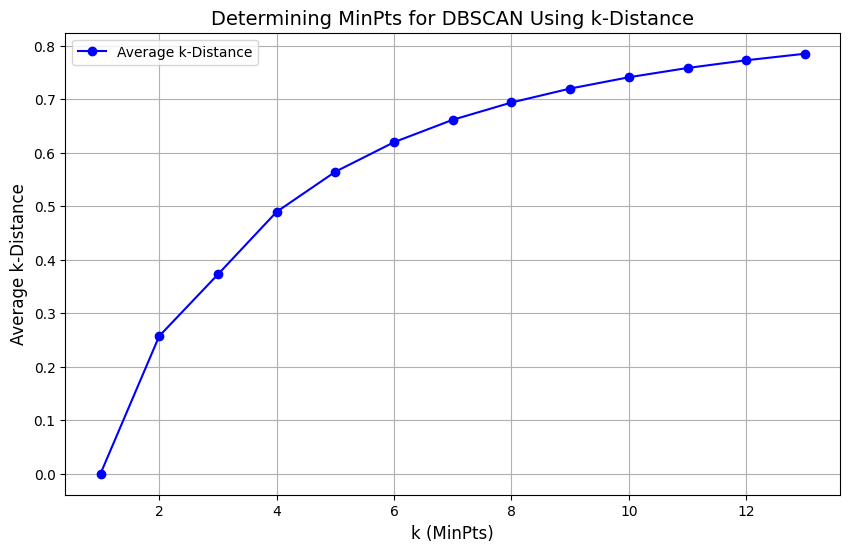

Optimal MinPts (k) identified: 13
sum
[0.         1.         1.         1.         1.         1.41421356
 1.41421356 1.41421356 1.41421356 1.41421356 1.41421356 1.41421356
 1.41421356]
k-Distances Shape (100,)
k-Distances: [15.3137085  12.         20.46677245 10.          0.          0.
  0.         15.72792206 10.         10.         20.46677245  0.
 19.51326071 10.          0.         16.14213562 10.         10.
  0.         22.92820323 11.         10.         10.         12.
 12.         16.14213562 15.3137085  10.         25.38452665 15.72792206
  0.         16.14213562 15.3137085  11.         12.         16.14213562
 13.07106781 15.3137085   0.         20.1489352  10.         19.51326071
  0.         16.55634919 12.         10.         10.          0.
 10.         18.24191173 15.72792206  0.          0.          0.
 19.19542346 12.         11.          0.          0.         18.87758622
  0.         12.         15.72792206  0.         16.55634919 11.
  0.         10.          0.  

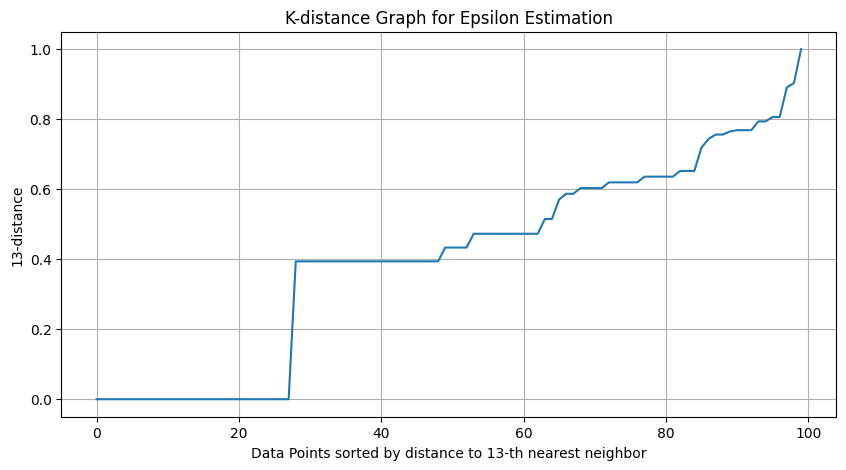

Optimal epsilon (eps) detected at index 92 with value: 0.7687068968840348
Epsilon value: 0.7687068968840348 and Minimum Points are: 13

No Cluster found, all points were noisy
0    100
Name: DBSCAN_Cluster, dtype: int64

Activity Log Columns: Index(['case:concept:name', 'time:timestamp', 'concept:name',
       'abstract_activity'],
      dtype='object') 

Total Routies: 1 ['routine_1']
Start Evaluating the routine_1:
Total Traces: 100

Unique Activities of routine_1: {'insertValue_password_Web', 'paste_Area_Web', 'goToUrl_www_webpage_com_Web', 'insertValue_ID_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButton_Button1_Web', 'clickButton_B2_Web', 'paste_Special_code_Web', 'clickButton_confirm_Web', 'clickButton_OK_Web', 'copy_B_Excel', 'waitResponse_www_webpage_com_ok_Web', 'insertValue_username_Web'} 

Unique Activities of ground truth model: {'insertValue_password_Web', 'paste_Area_Web', 'goToUrl_www_webpage_com_Web', 'insertValue_ID_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButt

replaying log with TBR, completed variants :: 100%|████████████████████████████████| 442/442 [00:00<00:00, 2406.29it/s]



Evaluation Scores:
Fitness:  0.91
Precision:  1.0
Generalization:  0.9
Simplicity:  1.0

Coverage: 1.00
Support: 0.93
Jaccard Coefficient: 1.00






parsing log, completed traces :: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 636.11it/s]



**  Total number of events:  1400
**  Total number of columns:  3
**  Total number of Traces:  100
**  Total number of unique activities:  13

**  Unique Activites:  ['openFile_Excel_Sheet1_data_xls' 'insertValue_username_Web'
 'insertValue_password_Web' 'clickButton_confirm_Web'
 'waitResponse_www_webpage_com_ok_Web' 'clickButton_Button1_Web'
 'clickButton_B2_Web' 'insertValue_ID_Web' 'copy_B_Excel'
 'paste_Special_code_Web' 'paste_Area_Web' 'clickButton_OK_Web'
 'goToUrl_www_webpage_com_Web']

**  Columns:  ['case:concept:name', 'time:timestamp', 'concept:name'] 

DBSCAN
freq




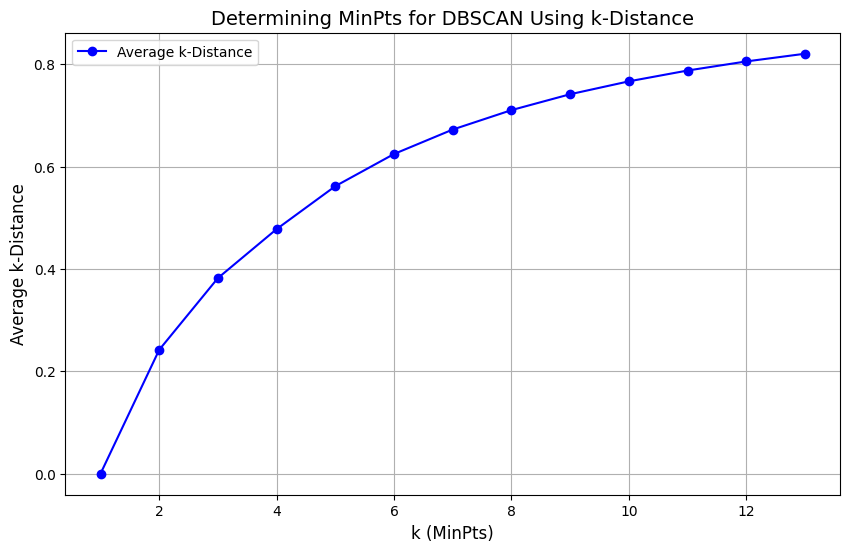

Optimal MinPts (k) identified: 13
sum
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
k-Distances Shape (100,)
k-Distances: [ 9.          0.         26.69693846  0.          0.         15.72792206
 11.         10.         15.3137085  16.55634919 11.          0.
 15.3137085  15.3137085   0.         14.3137085  16.14213562 14.89949494
 11.          9.         12.         15.3137085  16.14213562 24.9123907
  0.         16.55634919  0.          9.         10.          0.
 18.55974897 15.72792206 14.89949494  9.          0.          0.
 10.         18.24191173  0.         11.         12.         11.
  9.         11.          9.         10.         16.14213562 14.3137085
 15.3137085  12.          0.          0.         12.         11.
 11.          0.         11.          0.          9.         16.55634919
  9.         14.48528137 14.89949494  0.         10.         11.
 17.92407448 18.55974897 21.58845727  9.         14.48528137  9.
 20.46677245 15.72792206  0.          0.         15.3137085   0.


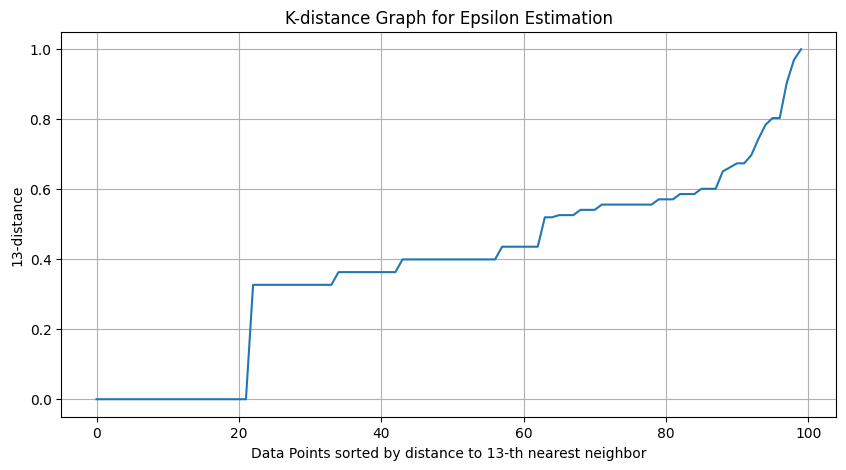

Optimal epsilon (eps) detected at index 87 with value: 0.6011975178021337
Epsilon value: 0.6011975178021337 and Minimum Points are: 13

No Cluster found, all points were noisy
0    100
Name: DBSCAN_Cluster, dtype: int64

Activity Log Columns: Index(['case:concept:name', 'time:timestamp', 'concept:name',
       'abstract_activity'],
      dtype='object') 

Total Routies: 1 ['routine_1']
Start Evaluating the routine_1:
Total Traces: 100

Unique Activities of routine_1: {'insertValue_password_Web', 'paste_Area_Web', 'insertValue_ID_Web', 'goToUrl_www_webpage_com_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButton_Button1_Web', 'clickButton_B2_Web', 'paste_Special_code_Web', 'clickButton_confirm_Web', 'clickButton_OK_Web', 'copy_B_Excel', 'waitResponse_www_webpage_com_ok_Web', 'insertValue_username_Web'} 

Unique Activities of ground truth model: {'insertValue_password_Web', 'paste_Area_Web', 'goToUrl_www_webpage_com_Web', 'insertValue_ID_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButt

replaying log with TBR, completed variants :: 100%|████████████████████████████████| 484/484 [00:00<00:00, 2674.67it/s]



Evaluation Scores:
Fitness:  0.909
Precision:  1.0
Generalization:  0.9
Simplicity:  1.0

Coverage: 1.00
Support: 0.93
Jaccard Coefficient: 1.00






parsing log, completed traces :: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 608.16it/s]



**  Total number of events:  1414
**  Total number of columns:  3
**  Total number of Traces:  100
**  Total number of unique activities:  13

**  Unique Activites:  ['openFile_Excel_Sheet1_data_xls' 'goToUrl_www_webpage_com_Web'
 'insertValue_username_Web' 'insertValue_password_Web'
 'clickButton_confirm_Web' 'clickButton_Button1_Web'
 'paste_Special_code_Web' 'clickButton_B2_Web' 'insertValue_ID_Web'
 'copy_B_Excel' 'paste_Area_Web' 'clickButton_OK_Web'
 'waitResponse_www_webpage_com_ok_Web']

**  Columns:  ['case:concept:name', 'time:timestamp', 'concept:name'] 

DBSCAN
freq




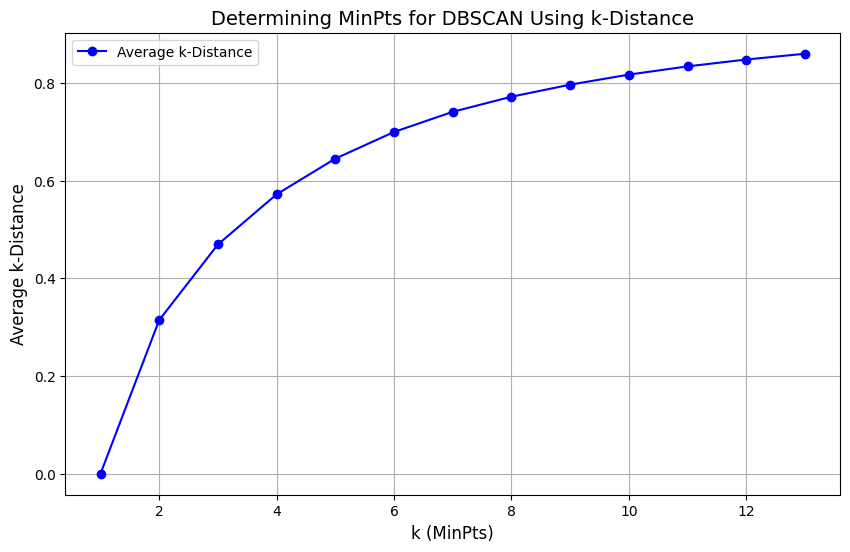

Optimal MinPts (k) identified: 13
sum
[0.         1.         1.41421356 1.41421356 1.41421356 1.41421356
 1.41421356 1.41421356 1.41421356 1.41421356 1.41421356 1.41421356
 1.41421356]
k-Distances Shape (100,)
k-Distances: [16.55634919 15.3137085   0.         12.         16.55634919  0.
 11.          0.         26.71034967 15.72792206  0.          0.
 19.51326071 14.72792206  0.          0.         15.72792206 21.80651841
  0.         17.82769817 16.55634919 20.46677245 10.         11.
 15.72792206 18.7812099  18.7812099   0.         12.          0.
 15.72792206 15.3137085  16.97056275  0.         11.          0.
  0.         15.72792206 12.         16.97056275 10.         16.55634919
 15.72792206  0.         21.80651841 16.14213562 12.         10.
 10.         15.3137085  16.97056275  0.         12.          0.
 15.3137085  19.09904715 16.97056275 11.         19.83109796 10.
  0.         16.14213562 15.3137085  11.         18.24191173 22.66025404
 12.         12.         10.         1

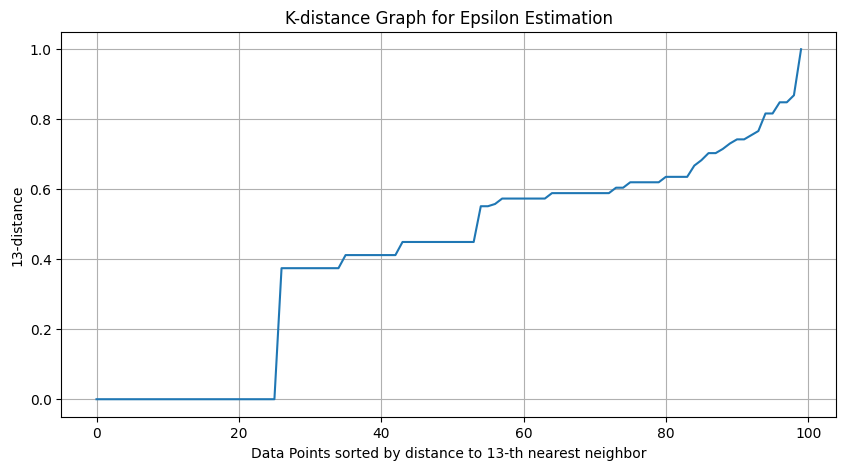

Optimal epsilon (eps) detected at index 97 with value: 0.8483698012579305
Epsilon value: 0.8483698012579305 and Minimum Points are: 13

No Cluster found, all points were noisy
0    100
Name: DBSCAN_Cluster, dtype: int64

Activity Log Columns: Index(['case:concept:name', 'time:timestamp', 'concept:name',
       'abstract_activity'],
      dtype='object') 

Total Routies: 1 ['routine_1']
Start Evaluating the routine_1:
Total Traces: 100

Unique Activities of routine_1: {'insertValue_password_Web', 'paste_Area_Web', 'goToUrl_www_webpage_com_Web', 'insertValue_ID_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButton_Button1_Web', 'paste_Special_code_Web', 'clickButton_B2_Web', 'clickButton_confirm_Web', 'clickButton_OK_Web', 'copy_B_Excel', 'waitResponse_www_webpage_com_ok_Web', 'insertValue_username_Web'} 

Unique Activities of ground truth model: {'insertValue_password_Web', 'paste_Area_Web', 'goToUrl_www_webpage_com_Web', 'insertValue_ID_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButt

replaying log with TBR, completed variants :: 100%|████████████████████████████████| 482/482 [00:00<00:00, 2748.89it/s]



Evaluation Scores:
Fitness:  0.901
Precision:  1.0
Generalization:  0.9
Simplicity:  1.0

Coverage: 1.00
Support: 0.93
Jaccard Coefficient: 1.00






parsing log, completed traces :: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 713.96it/s]



**  Total number of events:  1392
**  Total number of columns:  3
**  Total number of Traces:  100
**  Total number of unique activities:  13

**  Unique Activites:  ['openFile_Excel_Sheet1_data_xls' 'goToUrl_www_webpage_com_Web'
 'insertValue_username_Web' 'insertValue_password_Web'
 'clickButton_confirm_Web' 'waitResponse_www_webpage_com_ok_Web'
 'clickButton_Button1_Web' 'clickButton_B2_Web' 'insertValue_ID_Web'
 'copy_B_Excel' 'paste_Special_code_Web' 'paste_Area_Web'
 'clickButton_OK_Web']

**  Columns:  ['case:concept:name', 'time:timestamp', 'concept:name'] 

DBSCAN
freq




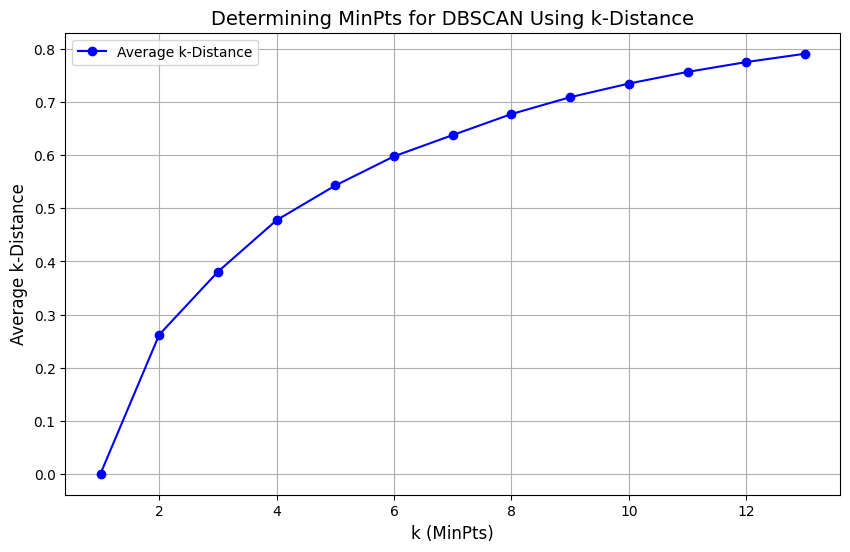

Optimal MinPts (k) identified: 13
sum
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
k-Distances Shape (100,)
k-Distances: [12.         11.         28.17546764  8.          0.         11.
 12.          8.         15.72792206 15.3137085   0.          6.
 19.19542346 12.         12.          0.         12.         15.3137085
  0.         16.97056275  6.          0.         22.12435565 16.14213562
 16.14213562 15.72792206  6.          6.         10.         11.
 15.72792206 12.         10.          0.          0.         11.
 15.72792206  0.         10.          8.         17.92407448 18.87758622
  0.         18.24191173 15.3137085  16.55634919  0.          0.
 10.          8.         10.         10.         10.         11.
  6.         10.         12.         25.72496154 15.72792206  0.
  0.         12.          0.         10.          0.         16.14213562
 11.         15.72792206  0.          0.         16.14213562 18.87758622
  0.         12.         11.         12.         19.41688439 15.

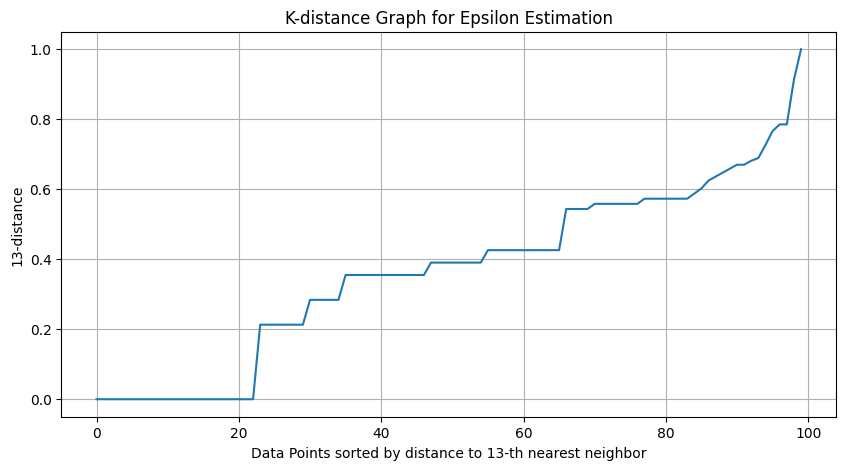

Optimal epsilon (eps) detected at index 83 with value: 0.5729145591286147
Epsilon value: 0.5729145591286147 and Minimum Points are: 13
-1    60
 0    33
 1     7
Name: DBSCAN_Cluster, dtype: int64

All noise points have been assigned to the nearest cluster.


 0    91
1     9
Name: DBSCAN_Cluster, dtype: int64 


Activity Log Columns: Index(['case:concept:name', 'time:timestamp', 'concept:name',
       'abstract_activity'],
      dtype='object') 

Total Routies: 2 ['routine_1', 'routine_2']
Start Evaluating the routine_1:
Total Traces: 91

Unique Activities of routine_1: {'insertValue_password_Web', 'paste_Area_Web', 'goToUrl_www_webpage_com_Web', 'insertValue_ID_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButton_Button1_Web', 'clickButton_B2_Web', 'paste_Special_code_Web', 'clickButton_confirm_Web', 'clickButton_OK_Web', 'copy_B_Excel', 'waitResponse_www_webpage_com_ok_Web', 'insertValue_username_Web'} 

Unique Activities of ground truth model: {'insertValue_password_Web', 'paste_Ar

replaying log with TBR, completed variants :: 100%|████████████████████████████████| 409/409 [00:00<00:00, 2965.69it/s]



Evaluation Scores:
Fitness:  0.911
Precision:  1.0
Generalization:  0.895
Simplicity:  1.0

Coverage: 1.00
Support: 0.93
Jaccard Coefficient: 1.00




Start Evaluating the routine_2:
Total Traces: 9

Unique Activities of routine_2: {'insertValue_password_Web', 'paste_Area_Web', 'goToUrl_www_webpage_com_Web', 'insertValue_ID_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButton_Button1_Web', 'clickButton_B2_Web', 'paste_Special_code_Web', 'clickButton_confirm_Web', 'clickButton_OK_Web', 'copy_B_Excel', 'waitResponse_www_webpage_com_ok_Web'} 

Unique Activities of ground truth model: {'insertValue_password_Web', 'paste_Area_Web', 'goToUrl_www_webpage_com_Web', 'insertValue_ID_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButton_B2_Web', 'paste_Special_code_Web', 'clickButton_Button1_Web', 'clickButton_confirm_Web', 'clickButton_OK_Web', 'copy_B_Excel', 'waitResponse_www_webpage_com_ok_Web', 'insertValue_username_Web'} 

JC Score of routine_2 is 0.9230769230769231 with r1log1

Maximum JC 

replaying log with TBR, completed variants :: 100%|█████████████████████████████████| 37/37 [00:00<00:00, 13097.24it/s]



Evaluation Scores:
Fitness:  0.9
Precision:  0.708
Generalization:  0.621
Simplicity:  1.0

Coverage: 1.00
Support: 0.86
Jaccard Coefficient: 0.92






parsing log, completed traces :: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 499.19it/s]



**  Total number of events:  1416
**  Total number of columns:  3
**  Total number of Traces:  100
**  Total number of unique activities:  13

**  Unique Activites:  ['openFile_Excel_Sheet1_data_xls' 'goToUrl_www_webpage_com_Web'
 'insertValue_username_Web' 'insertValue_password_Web'
 'clickButton_confirm_Web' 'clickButton_OK_Web'
 'waitResponse_www_webpage_com_ok_Web' 'clickButton_Button1_Web'
 'clickButton_B2_Web' 'insertValue_ID_Web' 'copy_B_Excel'
 'paste_Special_code_Web' 'paste_Area_Web']

**  Columns:  ['case:concept:name', 'time:timestamp', 'concept:name'] 

DBSCAN
freq




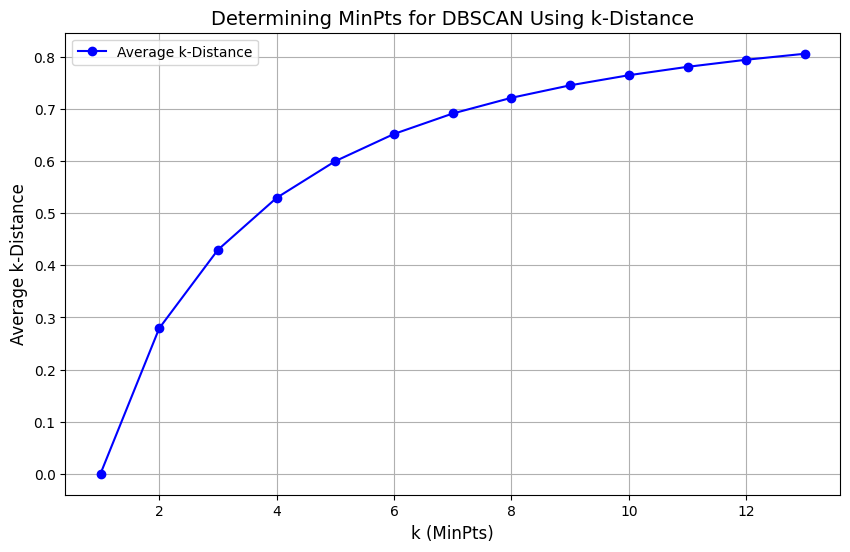

Optimal MinPts (k) identified: 13
sum
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
k-Distances Shape (100,)
k-Distances: [11.         10.         18.7812099  10.          0.          0.
 18.87758622 24.67632272  0.         14.89949494 15.3137085  12.
  0.          0.          0.         12.          0.         16.55634919
 12.         12.         12.          0.         10.         15.72792206
 15.3137085   0.          0.         14.72792206  0.          0.
  0.         16.14213562 24.9123907  14.72792206 23.73205081 16.14213562
  0.          0.         22.39230485 11.          0.          0.
  0.         16.14213562  0.         16.14213562 12.         15.72792206
  0.          0.         11.         19.51326071 12.         14.72792206
 15.72792206 20.1489352  11.         17.95278278 14.72792206 12.
 15.3137085  12.         12.         15.72792206  0.          0.
 16.14213562  0.         29.04936174 16.55634919 11.          0.
 16.14213562 15.72792206  0.         16.14213562 21.42491873 19

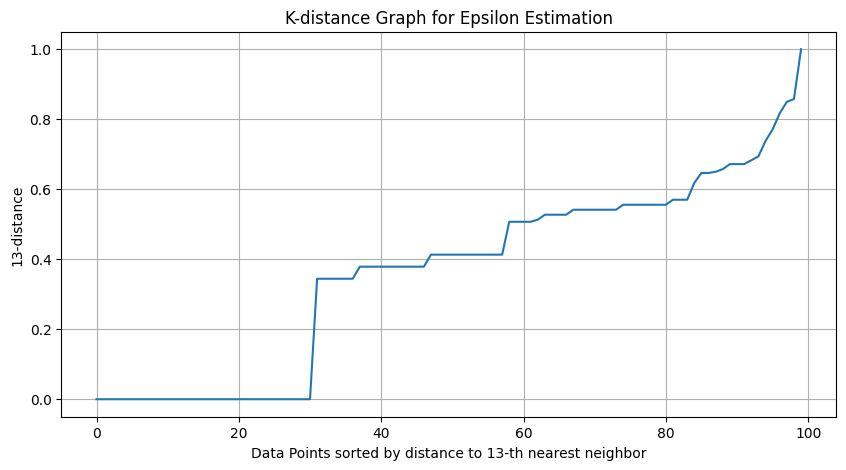

Optimal epsilon (eps) detected at index 91 with value: 0.6717276918365579
Epsilon value: 0.6717276918365579 and Minimum Points are: 13

No Cluster found, all points were noisy
0    100
Name: DBSCAN_Cluster, dtype: int64

Activity Log Columns: Index(['case:concept:name', 'time:timestamp', 'concept:name',
       'abstract_activity'],
      dtype='object') 

Total Routies: 1 ['routine_1']
Start Evaluating the routine_1:
Total Traces: 100

Unique Activities of routine_1: {'insertValue_password_Web', 'paste_Area_Web', 'goToUrl_www_webpage_com_Web', 'insertValue_ID_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButton_Button1_Web', 'clickButton_OK_Web', 'clickButton_B2_Web', 'clickButton_confirm_Web', 'paste_Special_code_Web', 'copy_B_Excel', 'waitResponse_www_webpage_com_ok_Web', 'insertValue_username_Web'} 

Unique Activities of ground truth model: {'insertValue_password_Web', 'paste_Area_Web', 'goToUrl_www_webpage_com_Web', 'insertValue_ID_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButt

replaying log with TBR, completed variants :: 100%|████████████████████████████████| 485/485 [00:00<00:00, 3014.99it/s]



Evaluation Scores:
Fitness:  0.91
Precision:  1.0
Generalization:  0.901
Simplicity:  1.0

Coverage: 1.00
Support: 0.93
Jaccard Coefficient: 1.00






parsing log, completed traces :: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 691.50it/s]



**  Total number of events:  1434
**  Total number of columns:  3
**  Total number of Traces:  100
**  Total number of unique activities:  13

**  Unique Activites:  ['openFile_Excel_Sheet1_data_xls' 'goToUrl_www_webpage_com_Web'
 'insertValue_username_Web' 'insertValue_password_Web'
 'clickButton_confirm_Web' 'waitResponse_www_webpage_com_ok_Web'
 'clickButton_Button1_Web' 'clickButton_B2_Web' 'insertValue_ID_Web'
 'copy_B_Excel' 'paste_Special_code_Web' 'paste_Area_Web'
 'clickButton_OK_Web']

**  Columns:  ['case:concept:name', 'time:timestamp', 'concept:name'] 

DBSCAN
freq




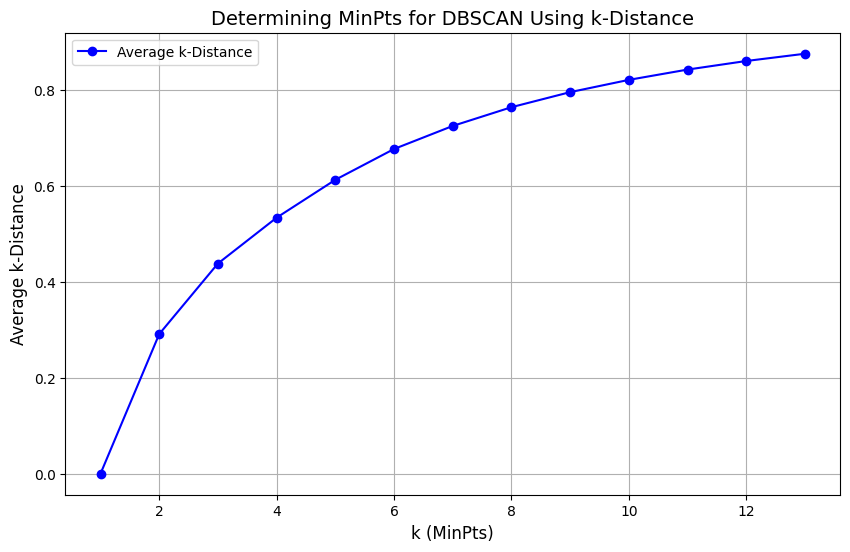

Optimal MinPts (k) identified: 13
sum
[0.         0.         1.         1.         1.41421356 1.73205081
 1.73205081 2.         2.         2.         2.         2.
 2.        ]
k-Distances Shape (100,)
k-Distances: [18.87831518  8.          0.         12.         14.89949494 11.
 11.          9.          0.          0.         20.78460969  0.
 11.          0.         16.14213562 10.         19.51326071 11.
  0.         12.         12.         19.51326071 11.          0.
 21.85640646  9.         12.         14.48528137 29.53865789 10.
 16.97056275 14.89949494 14.89949494 21.27062002 12.         11.
 18.87758622 11.         16.55634919  8.         20.1489352  17.92407448
  9.          0.         12.         15.3137085   0.         10.
  0.         16.55634919 18.87758622  9.         16.97056275 10.
 16.14213562 12.         16.55634919 18.55974897 11.         18.55974897
 16.55634919  0.          0.          0.         14.48528137 15.72792206
 23.19615242  0.         24.766859   10.      

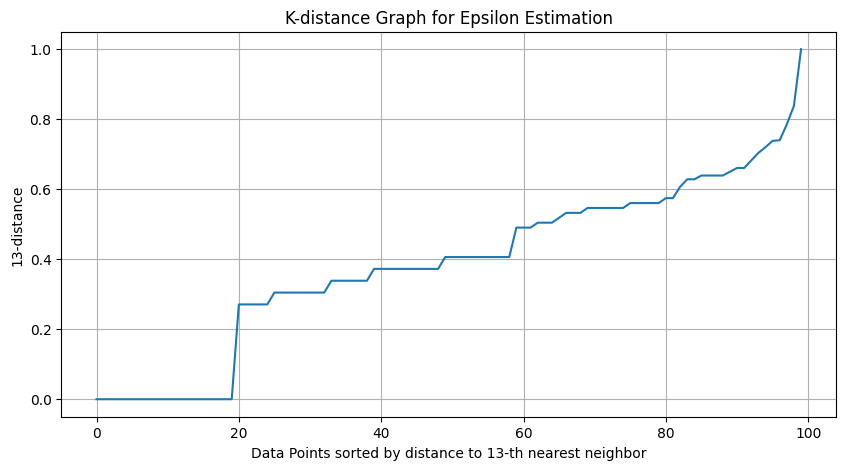

Optimal epsilon (eps) detected at index 88 with value: 0.6391053800542302
Epsilon value: 0.6391053800542302 and Minimum Points are: 13
-1    62
 2    25
 0     7
 1     6
Name: DBSCAN_Cluster, dtype: int64

All noise points have been assigned to the nearest cluster.


 2    83
0     9
1     8
Name: DBSCAN_Cluster, dtype: int64 


Activity Log Columns: Index(['case:concept:name', 'time:timestamp', 'concept:name',
       'abstract_activity'],
      dtype='object') 

Total Routies: 3 ['routine_3', 'routine_1', 'routine_2']
Start Evaluating the routine_3:
Total Traces: 83

Unique Activities of routine_3: {'insertValue_password_Web', 'paste_Area_Web', 'goToUrl_www_webpage_com_Web', 'insertValue_ID_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButton_Button1_Web', 'clickButton_B2_Web', 'paste_Special_code_Web', 'clickButton_confirm_Web', 'clickButton_OK_Web', 'copy_B_Excel', 'waitResponse_www_webpage_com_ok_Web', 'insertValue_username_Web'} 

Unique Activities of ground truth model: {'insert

replaying log with TBR, completed variants :: 100%|████████████████████████████████| 501/501 [00:00<00:00, 3068.75it/s]



Evaluation Scores:
Fitness:  0.909
Precision:  1.0
Generalization:  0.891
Simplicity:  1.0

Coverage: 1.00
Support: 0.93
Jaccard Coefficient: 1.00




Start Evaluating the routine_1:
Total Traces: 9

Unique Activities of routine_1: {'insertValue_password_Web', 'paste_Area_Web', 'goToUrl_www_webpage_com_Web', 'insertValue_ID_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButton_Button1_Web', 'clickButton_B2_Web', 'paste_Special_code_Web', 'clickButton_confirm_Web', 'clickButton_OK_Web', 'copy_B_Excel', 'waitResponse_www_webpage_com_ok_Web', 'insertValue_username_Web'} 

Unique Activities of ground truth model: {'insertValue_password_Web', 'paste_Area_Web', 'goToUrl_www_webpage_com_Web', 'insertValue_ID_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButton_B2_Web', 'paste_Special_code_Web', 'clickButton_OK_Web', 'clickButton_confirm_Web', 'clickButton_Button1_Web', 'copy_B_Excel', 'waitResponse_www_webpage_com_ok_Web', 'insertValue_username_Web'} 

JC Score of routine_1 is 1.0 with r1log1

replaying log with TBR, completed variants :: 100%|██████████████████████████████████| 89/89 [00:00<00:00, 2615.07it/s]



Evaluation Scores:
Fitness:  0.899
Precision:  0.984
Generalization:  0.675
Simplicity:  1.0

Coverage: 1.00
Support: 0.93
Jaccard Coefficient: 1.00




Start Evaluating the routine_2:
Total Traces: 8

Unique Activities of routine_2: {'insertValue_password_Web', 'paste_Area_Web', 'goToUrl_www_webpage_com_Web', 'insertValue_ID_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButton_Button1_Web', 'clickButton_B2_Web', 'paste_Special_code_Web', 'clickButton_confirm_Web', 'clickButton_OK_Web', 'copy_B_Excel', 'waitResponse_www_webpage_com_ok_Web', 'insertValue_username_Web'} 

Unique Activities of ground truth model: {'insertValue_password_Web', 'paste_Area_Web', 'goToUrl_www_webpage_com_Web', 'insertValue_ID_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButton_B2_Web', 'clickButton_OK_Web', 'paste_Special_code_Web', 'clickButton_confirm_Web', 'clickButton_Button1_Web', 'copy_B_Excel', 'waitResponse_www_webpage_com_ok_Web', 'insertValue_username_Web'} 

JC Score of routine_2 is 1.0 with r1lo

replaying log with TBR, completed variants :: 100%|██████████████████████████████████| 45/45 [00:00<00:00, 6399.39it/s]



Evaluation Scores:
Fitness:  0.882
Precision:  0.97
Generalization:  0.628
Simplicity:  1.0

Coverage: 1.00
Support: 0.93
Jaccard Coefficient: 1.00






parsing log, completed traces :: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 731.16it/s]



**  Total number of events:  1400
**  Total number of columns:  3
**  Total number of Traces:  100
**  Total number of unique activities:  13

**  Unique Activites:  ['openFile_Excel_Sheet1_data_xls' 'goToUrl_www_webpage_com_Web'
 'insertValue_username_Web' 'insertValue_password_Web'
 'clickButton_confirm_Web' 'waitResponse_www_webpage_com_ok_Web'
 'clickButton_Button1_Web' 'clickButton_B2_Web' 'insertValue_ID_Web'
 'copy_B_Excel' 'paste_Special_code_Web' 'paste_Area_Web'
 'clickButton_OK_Web']

**  Columns:  ['case:concept:name', 'time:timestamp', 'concept:name'] 

DBSCAN
freq




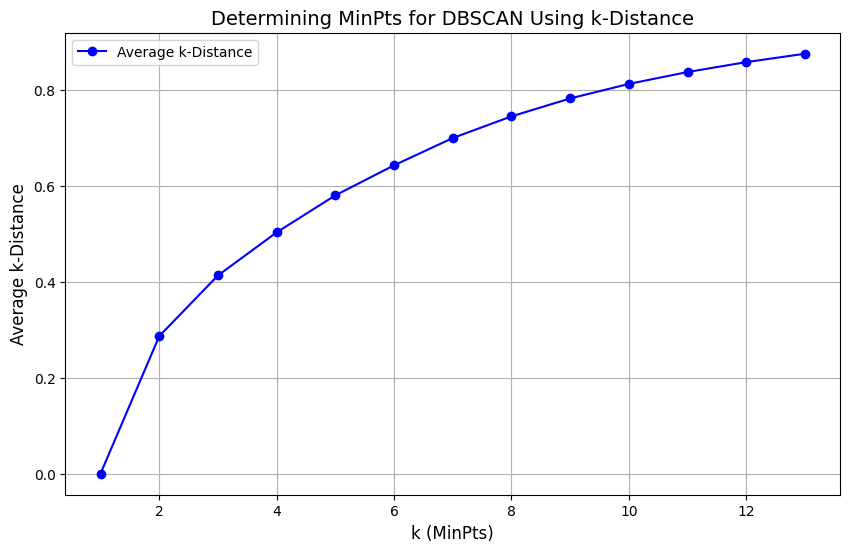

Optimal MinPts (k) identified: 13
sum
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
k-Distances Shape (100,)
k-Distances: [ 0.          9.          7.          0.         11.         20.1489352
 10.         16.55634919 13.65685425  7.          8.         15.3137085
  0.          0.          0.         19.83109796 16.97056275  0.
 14.89949494 16.14213562 14.48528137 14.07106781 12.         12.
  0.          9.         18.14553541 20.78460969  9.         14.07106781
 16.14213562 16.55634919 19.56047793 18.87758622 14.89949494 10.
 14.48528137  0.         15.72792206 15.72792206 11.         23.73205081
 11.         10.         15.72792206 16.55634919  0.         18.87758622
  0.          0.         22.66025404 10.         10.         16.55634919
  9.         14.07106781 10.         18.46337266 25.82478139  9.
 10.         14.89949494 15.72792206  8.         28.04540769 15.3137085
 11.         11.         10.          8.         15.3137085  12.
 15.72792206 15.72792206  7.          0.          

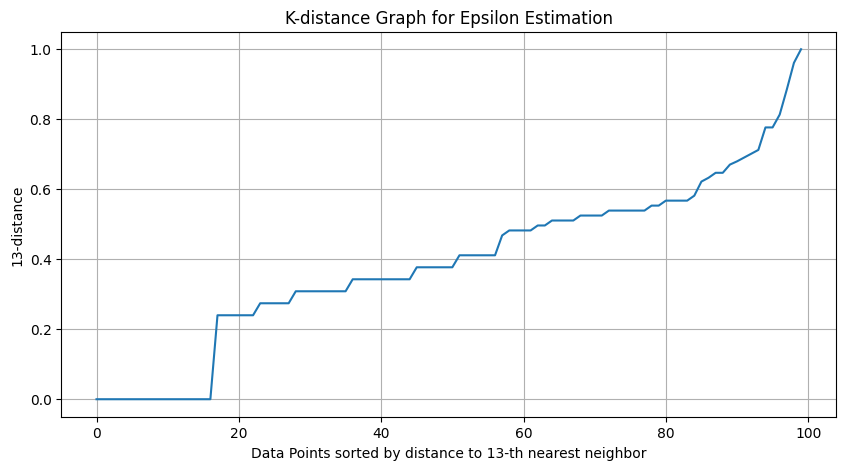

Optimal epsilon (eps) detected at index 83 with value: 0.5673780310165484
Epsilon value: 0.5673780310165484 and Minimum Points are: 13
-1    59
 2    28
 0     7
 1     6
Name: DBSCAN_Cluster, dtype: int64

All noise points have been assigned to the nearest cluster.


 2    82
0    11
1     7
Name: DBSCAN_Cluster, dtype: int64 


Activity Log Columns: Index(['case:concept:name', 'time:timestamp', 'concept:name',
       'abstract_activity'],
      dtype='object') 

Total Routies: 3 ['routine_3', 'routine_2', 'routine_1']
Start Evaluating the routine_3:
Total Traces: 82

Unique Activities of routine_3: {'insertValue_password_Web', 'paste_Area_Web', 'goToUrl_www_webpage_com_Web', 'insertValue_ID_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButton_Button1_Web', 'clickButton_B2_Web', 'paste_Special_code_Web', 'clickButton_confirm_Web', 'clickButton_OK_Web', 'copy_B_Excel', 'waitResponse_www_webpage_com_ok_Web', 'insertValue_username_Web'} 

Unique Activities of ground truth model: {'insert

replaying log with TBR, completed variants :: 100%|████████████████████████████████| 494/494 [00:00<00:00, 2911.99it/s]



Evaluation Scores:
Fitness:  0.91
Precision:  1.0
Generalization:  0.891
Simplicity:  1.0

Coverage: 1.00
Support: 0.93
Jaccard Coefficient: 1.00




Start Evaluating the routine_2:
Total Traces: 7

Unique Activities of routine_2: {'insertValue_password_Web', 'paste_Area_Web', 'goToUrl_www_webpage_com_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButton_Button1_Web', 'clickButton_B2_Web', 'paste_Special_code_Web', 'clickButton_confirm_Web', 'clickButton_OK_Web', 'copy_B_Excel', 'waitResponse_www_webpage_com_ok_Web', 'insertValue_username_Web'} 

Unique Activities of ground truth model: {'insertValue_password_Web', 'paste_Area_Web', 'insertValue_ID_Web', 'goToUrl_www_webpage_com_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButton_B2_Web', 'clickButton_OK_Web', 'paste_Special_code_Web', 'clickButton_confirm_Web', 'clickButton_Button1_Web', 'copy_B_Excel', 'waitResponse_www_webpage_com_ok_Web', 'insertValue_username_Web'} 

JC Score of routine_2 is 0.9230769230769231 with r1log1

Maximu

replaying log with TBR, completed variants :: 100%|██████████████████████████████████| 19/19 [00:00<00:00, 2381.56it/s]



Evaluation Scores:
Fitness:  0.837
Precision:  0.9
Generalization:  0.54
Simplicity:  1.0

Coverage: 1.00
Support: 0.86
Jaccard Coefficient: 0.92




Start Evaluating the routine_1:
Total Traces: 11

Unique Activities of routine_1: {'insertValue_password_Web', 'paste_Area_Web', 'goToUrl_www_webpage_com_Web', 'insertValue_ID_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButton_Button1_Web', 'clickButton_B2_Web', 'paste_Special_code_Web', 'clickButton_confirm_Web', 'clickButton_OK_Web', 'copy_B_Excel', 'waitResponse_www_webpage_com_ok_Web', 'insertValue_username_Web'} 

Unique Activities of ground truth model: {'insertValue_password_Web', 'paste_Area_Web', 'insertValue_ID_Web', 'goToUrl_www_webpage_com_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButton_B2_Web', 'paste_Special_code_Web', 'clickButton_OK_Web', 'clickButton_confirm_Web', 'clickButton_Button1_Web', 'copy_B_Excel', 'waitResponse_www_webpage_com_ok_Web', 'insertValue_username_Web'} 

JC Score of routine_1 is 1.0 with r1log1

replaying log with TBR, completed variants :: 100%|██████████████████████████████████| 54/54 [00:00<00:00, 3156.51it/s]



Evaluation Scores:
Fitness:  0.874
Precision:  0.957
Generalization:  0.674
Simplicity:  1.0

Coverage: 1.00
Support: 0.93
Jaccard Coefficient: 1.00






parsing log, completed traces :: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 728.12it/s]



**  Total number of events:  1410
**  Total number of columns:  3
**  Total number of Traces:  100
**  Total number of unique activities:  13

**  Unique Activites:  ['openFile_Excel_Sheet1_data_xls' 'goToUrl_www_webpage_com_Web'
 'insertValue_password_Web' 'insertValue_username_Web'
 'clickButton_confirm_Web' 'waitResponse_www_webpage_com_ok_Web'
 'clickButton_Button1_Web' 'clickButton_B2_Web' 'insertValue_ID_Web'
 'paste_Special_code_Web' 'copy_B_Excel' 'paste_Area_Web'
 'clickButton_OK_Web']

**  Columns:  ['case:concept:name', 'time:timestamp', 'concept:name'] 

DBSCAN
freq




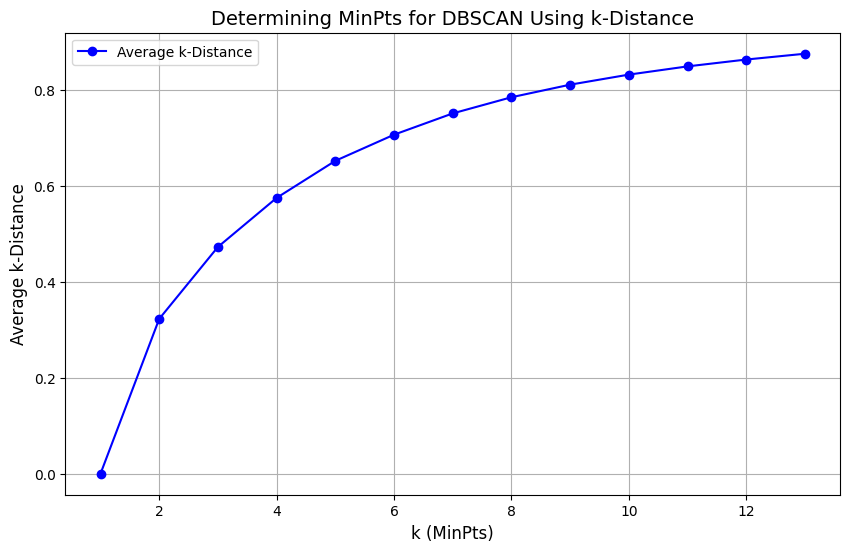

Optimal MinPts (k) identified: 13
sum
[0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
k-Distances Shape (100,)
k-Distances: [24.         18.87758622 12.         10.         16.14213562  0.
  0.         11.         14.89949494 19.19542346 15.3137085  12.
 19.83109796  0.          0.         22.34241679 12.         20.1489352
 20.1489352  15.72792206  0.          9.         10.         16.14213562
 11.         20.1489352  12.         11.         16.14213562  9.
  0.         11.         15.72792206 12.         20.1489352  19.19542346
  0.         10.         11.          0.         10.         10.
 16.14213562 12.         16.14213562  0.          9.         18.7812099
  0.         11.         15.72792206 11.         15.72792206 16.14213562
 15.72792206 12.         14.89949494 12.         14.89949494 16.14213562
 12.          0.         12.          0.          0.         16.14213562
  9.         12.         14.89949494  0.         16.55634919 14.89949494
  0.         12.         15.72792206  0. 

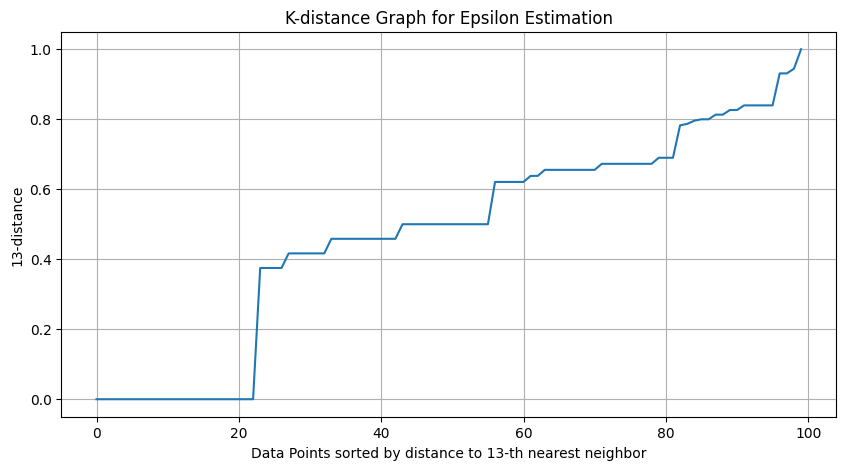

Optimal epsilon (eps) detected at index 95 with value: 0.8395389666847902
Epsilon value: 0.8395389666847902 and Minimum Points are: 13

No Cluster found, all points were noisy
0    100
Name: DBSCAN_Cluster, dtype: int64

Activity Log Columns: Index(['case:concept:name', 'time:timestamp', 'concept:name',
       'abstract_activity'],
      dtype='object') 

Total Routies: 1 ['routine_1']
Start Evaluating the routine_1:
Total Traces: 100

Unique Activities of routine_1: {'insertValue_password_Web', 'paste_Area_Web', 'goToUrl_www_webpage_com_Web', 'insertValue_ID_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButton_Button1_Web', 'clickButton_B2_Web', 'paste_Special_code_Web', 'clickButton_confirm_Web', 'clickButton_OK_Web', 'copy_B_Excel', 'waitResponse_www_webpage_com_ok_Web', 'insertValue_username_Web'} 

Unique Activities of ground truth model: {'insertValue_password_Web', 'paste_Area_Web', 'goToUrl_www_webpage_com_Web', 'insertValue_ID_Web', 'openFile_Excel_Sheet1_data_xls', 'clickButt

replaying log with TBR, completed variants :: 100%|████████████████████████████████| 512/512 [00:00<00:00, 3158.40it/s]



Evaluation Scores:
Fitness:  0.902
Precision:  1.0
Generalization:  0.9
Simplicity:  1.0

Coverage: 1.00
Support: 0.93
Jaccard Coefficient: 1.00






In [9]:
log_number = 1
noise_prob = 0.1
cross_val_results = []

for variant in range(1, 11):

    cpn_ground_truth_dir = f"GT_Models/log{log_number}/"
    file_path = f"Transformed_Logs_and_Results/Our/Transformed_Log_With_Noise_{noise_prob}/log{log_number}/noisy_transform_log{log_number}_{variant}.xes"
    
    result_dic = {
        'Metrics':['Routine', "Traces", "Length", 'Fitness','Precision','Generalization','Simplicity', 'F_Score', 'coverage', 'Support', 'JC'],
    }
    
    log = UI_read_log(file_path)
    activity_log, cluster_map = UI_clustering(log)
    result_dic = UI_logs_evaluate(activity_log, cluster_map)
    
    
    cross_val_results.append(result_dic)

In [10]:
# Run cross-validation summary
iteration_results, final_averages = cross_validation_summary(cross_val_results)


✅ Cross-Validation Iteration Results:
+-------+----------+----------------+-----------+-------------+-------+--------+-----------+------------+-----------+-------+
|       |   Traces |   Trace Length |   Fitness |   Precision |   Gen |   Simp |   F-Score |   Coverage |   Support |    JC |
|-------+----------+----------------+-----------+-------------+-------+--------+-----------+------------+-----------+-------|
| CV 1  |      100 |         13     |     0.885 |       0.994 | 0.788 |      1 |     0.936 |          1 |     0.929 | 1     |
| CV 2  |      100 |         13     |     0.89  |       1     | 0.901 |      1 |     0.942 |          1 |     0.929 | 1     |
| CV 3  |      100 |         13     |     0.91  |       1     | 0.9   |      1 |     0.953 |          1 |     0.929 | 1     |
| CV 4  |      100 |         13     |     0.909 |       1     | 0.9   |      1 |     0.952 |          1 |     0.929 | 1     |
| CV 5  |      100 |         13     |     0.901 |       1     | 0.9   |      1 

In [20]:
results_df = pd.concat([iteration_results, final_averages])

outputfile = f"Transformed_Logs_and_Results/Our/Transformed_Log_With_Noise_{noise_prob}/log{log_number}_reuslts.csv"
results_df.to_csv(outputfile)